In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import os
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout,LSTM

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import datetime
from datetime import date, timedelta
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')

data_path = 'D:/universidad/universidad 4/TFG/recursos para el desarrollo/datos procesados/OD'

In [2]:
delta = e_date - i_date

target_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    target_days.append(day)

In [3]:
def read_OD_fn(source_type):
    ods = {}
    for date in tqdm_notebook(target_days):
        od_date= pd.read_csv(os.path.join(data_path, 'date_{}_OD_{}.csv'.format(source_type,date.strftime('%Y-%m-%d'))), 
                            index_col=0)
        ods[date] = od_date
    return ods

In [4]:
ine_ods = read_OD_fn('INE')

  0%|          | 0/81 [00:00<?, ?it/s]

# Serializar los datos

In [5]:
lista_ine1 = []
lista_ine2 = []
lista_ine3 = []
lista_ine4 = []
lista_ine5 = []

for date in tqdm_notebook(target_days):
    lista_ine1.append(ine_ods[date].loc['18GU','total'])
    lista_ine2.append(ine_ods[date].loc['013B','total'])
    lista_ine3.append(ine_ods[date].loc['021S','total'])
    lista_ine4.append(ine_ods[date].loc['219M','total'])
    lista_ine5.append(ine_ods[date].loc['01CA','total'])

  0%|          | 0/81 [00:00<?, ?it/s]

In [6]:
df_ine1 = pd.DataFrame (lista_ine1, columns = ['Viajes'], index= target_days)
df_ine2 = pd.DataFrame (lista_ine2, columns = ['Viajes'], index= target_days)
df_ine3 = pd.DataFrame (lista_ine3, columns = ['Viajes'], index= target_days)
df_ine4 = pd.DataFrame (lista_ine4, columns = ['Viajes'], index= target_days)
df_ine5 = pd.DataFrame (lista_ine5, columns = ['Viajes'], index= target_days)

In [7]:
lista_ine = []

df = df_ine1 + df_ine2 + df_ine3 + df_ine4 + df_ine5

In [8]:
df.head()

,Viajes
2020-04-01,3314
2020-04-02,3220
2020-04-03,3934
2020-04-04,3141
2020-04-05,2520


In [9]:
del ine_ods

# Visualización de datos

In [10]:
print(df.index.min())
print(df.index.max())

2020-04-01 00:00:00
2020-06-20 00:00:00


In [11]:
print(len(df['2020']))

81


In [12]:
df.describe()

,Viajes
count,81.000000
mean,4188.802469
std,922.684743
min,2282.000000
25%,3503.000000
50%,4243.000000
75%,4933.000000
max,5827.000000


In [13]:
meses = df.resample('M').mean()
meses

,Viajes
2020-04-30,3410.966667
2020-05-31,4262.193548
2020-06-30,5241.800000


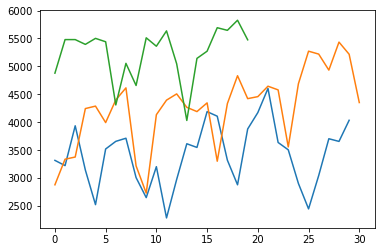

In [14]:
abril = df['2020-04-01':'2020-04-30']
plt.plot(abril.values)
mayo = df['2020-05-01':'2020-05-31']
plt.plot(mayo.values)
junio = df['2020-06-01':'2020-06-20']
plt.plot(junio.values)

# Preprocesado de datos

In [15]:
dataset = df.values
dataset = dataset.astype('float32')

In [16]:
# normalizamos el conjunto de datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Dividimos los datos en sets de entrenamiento y validacion

In [17]:
#dividimos nuestros valores entre sets de entrenamiento y de test
n_train_days = 60
train = dataset[:n_train_days, :]
test = dataset[n_train_days:, :]

print(len(train), len(test))

60 21


In [18]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [19]:
# dividimos en entradas y salidas
look_back = 7

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(len(trainX), len(testY))

53 14


In [20]:
print(trainX)

[[0.29111427 0.26459807 0.46600848 0.24231315 0.06713682 0.3486601
  0.38730603]
 [0.26459807 0.46600848 0.24231315 0.06713682 0.3486601  0.38730603
  0.40310293]
 [0.46600848 0.24231315 0.06713682 0.3486601  0.38730603 0.40310293
  0.20394921]
 [0.24231315 0.06713682 0.3486601  0.38730603 0.40310293 0.20394921
  0.10267985]
 [0.06713682 0.3486601  0.38730603 0.40310293 0.20394921 0.10267985
  0.25923836]
 [0.3486601  0.38730603 0.40310293 0.20394921 0.10267985 0.25923836
  0.        ]
 [0.38730603 0.40310293 0.20394921 0.10267985 0.25923836 0.
  0.19464034]
 [0.40310293 0.20394921 0.10267985 0.25923836 0.         0.19464034
  0.37517637]
 [0.20394921 0.10267985 0.25923836 0.         0.19464034 0.37517637
  0.3565585 ]
 [0.10267985 0.25923836 0.         0.19464034 0.37517637 0.3565585
  0.53765875]
 [0.25923836 0.         0.19464034 0.37517637 0.3565585  0.53765875
  0.5145275 ]
 [0.         0.19464034 0.37517637 0.3565585  0.53765875 0.5145275
  0.29196054]
 [0.19464034 0.37517637 0.3

In [21]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [22]:
print(trainX)

[[[0.29111427]
  [0.26459807]
  [0.46600848]
  [0.24231315]
  [0.06713682]
  [0.3486601 ]
  [0.38730603]]

 [[0.26459807]
  [0.46600848]
  [0.24231315]
  [0.06713682]
  [0.3486601 ]
  [0.38730603]
  [0.40310293]]

 [[0.46600848]
  [0.24231315]
  [0.06713682]
  [0.3486601 ]
  [0.38730603]
  [0.40310293]
  [0.20394921]]

 [[0.24231315]
  [0.06713682]
  [0.3486601 ]
  [0.38730603]
  [0.40310293]
  [0.20394921]
  [0.10267985]]

 [[0.06713682]
  [0.3486601 ]
  [0.38730603]
  [0.40310293]
  [0.20394921]
  [0.10267985]
  [0.25923836]]

 [[0.3486601 ]
  [0.38730603]
  [0.40310293]
  [0.20394921]
  [0.10267985]
  [0.25923836]
  [0.        ]]

 [[0.38730603]
  [0.40310293]
  [0.20394921]
  [0.10267985]
  [0.25923836]
  [0.        ]
  [0.19464034]]

 [[0.40310293]
  [0.20394921]
  [0.10267985]
  [0.25923836]
  [0.        ]
  [0.19464034]
  [0.37517637]]

 [[0.20394921]
  [0.10267985]
  [0.25923836]
  [0.        ]
  [0.19464034]
  [0.37517637]
  [0.3565585 ]]

 [[0.10267985]
  [0.25923836]
  [0.  

In [23]:
print(trainY)

[0.40310293 0.20394921 0.10267985 0.25923836 0.         0.19464034
 0.37517637 0.3565585  0.53765875 0.5145275  0.29196054 0.16755998
 0.44992954 0.5328632  0.65500706 0.38166434 0.34442878 0.17433006
 0.04569817 0.21438646 0.40056425 0.387024   0.49393517 0.16755998
 0.29703808 0.3080395  0.5531735  0.5655853  0.4823696  0.59689707
 0.6578279  0.2631876  0.12552893 0.5221439  0.59576875 0.62736255
 0.5593794  0.5379408  0.58194643 0.28688294 0.57856137 0.719323
 0.60338503 0.61354023 0.6662906  0.64767283 0.3590973  0.6787024
 0.84344155 0.82877296 0.7478139  0.88942176 0.8279267 ]


# Creamos la red neuronal

In [24]:
def crear_modeloFF():
    model = Sequential() 
    model.add(LSTM(20, input_shape=(look_back,1), return_sequences=True))
    model.add(LSTM(50, input_shape=(look_back,1), return_sequences=True))
    model.add(Dropout(0.30))
    model.add(LSTM(100, input_shape=(look_back,1)))
    model.add(Dropout(0.30))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    return model

In [25]:
model = crear_modeloFF()

history=model.fit(trainX, trainY, epochs=200, validation_data=(testX,testY), batch_size=1, verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 20)             1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 50)             14200     
_________________________________________________________________
dropout (Dropout)            (None, 7, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 76,461
Trainable params: 76,461
Non-trainable params: 0
____________________________________________________

Epoch 123/200
53/53 - 0s - loss: 0.0228 - val_loss: 0.0202
Epoch 124/200
53/53 - 0s - loss: 0.0228 - val_loss: 0.0278
Epoch 125/200
53/53 - 0s - loss: 0.0247 - val_loss: 0.0289
Epoch 126/200
53/53 - 0s - loss: 0.0225 - val_loss: 0.0249
Epoch 127/200
53/53 - 0s - loss: 0.0202 - val_loss: 0.0415
Epoch 128/200
53/53 - 0s - loss: 0.0238 - val_loss: 0.0298
Epoch 129/200
53/53 - 0s - loss: 0.0218 - val_loss: 0.0238
Epoch 130/200
53/53 - 0s - loss: 0.0168 - val_loss: 0.0233
Epoch 131/200
53/53 - 0s - loss: 0.0236 - val_loss: 0.0603
Epoch 132/200
53/53 - 0s - loss: 0.0221 - val_loss: 0.0258
Epoch 133/200
53/53 - 0s - loss: 0.0184 - val_loss: 0.0205
Epoch 134/200
53/53 - 0s - loss: 0.0223 - val_loss: 0.0196
Epoch 135/200
53/53 - 0s - loss: 0.0201 - val_loss: 0.0249
Epoch 136/200
53/53 - 0s - loss: 0.0227 - val_loss: 0.0285
Epoch 137/200
53/53 - 0s - loss: 0.0188 - val_loss: 0.0210
Epoch 138/200
53/53 - 0s - loss: 0.0211 - val_loss: 0.0214
Epoch 139/200
53/53 - 0s - loss: 0.0185 - val_loss: 0.02

# Visualizamos resultados

In [26]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


def compute_metrics_fn(y_valid_resc, y_hat_resc):
    mae_ = mean_absolute_error(y_valid_resc, y_hat_resc)
    mse_ = mean_squared_error(y_valid_resc, y_hat_resc)
    rmse_ = mean_squared_error(y_valid_resc, y_hat_resc, squared = False)
    cvrmse_ = rmse_/np.mean(y_valid_resc)*100 # it is a percentage
    mape_ = mape(y_valid_resc, y_hat_resc)
    
    return mae_, mse_, rmse_, cvrmse_, mape_

In [27]:
# hacemos las predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invertimos las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY_scalerInverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_scalerInverse = scaler.inverse_transform([testY])

In [28]:
# calculamos las metricas de error
trainScore_MAE, trainScore_MSE, trainScore_RMSE, trainScore_CVRMSE, trainScore_MAPE  =  compute_metrics_fn(trainY_scalerInverse[0], trainPredict[:,0])
print('Resultado del entrenamiento: %.2f MAE' % (trainScore_MAE))
print('Resultado del entrenamiento: %.2f MSE' % (trainScore_MSE))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore_RMSE))
print('Resultado del entrenamiento: %.2f CVRMSE' % (trainScore_CVRMSE))
print('Resultado del entrenamiento: %.2f MAPE \n' % (trainScore_MAPE))

testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(testY_scalerInverse[0], testPredict[:,0])
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del entrenamiento: 350.07 MAE
Resultado del entrenamiento: 187869.77 MSE
Resultado del entrenamiento: 433.44 RMSE
Resultado del entrenamiento: 11.11 CVRMSE
Resultado del entrenamiento: 9.64 MAPE 

Resultado del test: 414.44 MAE
Resultado del test: 254817.24 MSE
Resultado del test: 504.79 RMSE
Resultado del test: 9.73 CVRMSE
Resultado del test: 8.35 MAPE


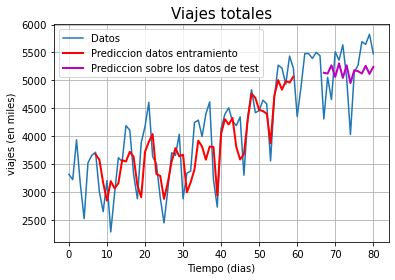

In [29]:
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# predicciones del test de cambio para plotear
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset), :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.title("Viajes totales", fontsize = 15)
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.show()

In [30]:
results=testPredict
print(len(results))

14


In [31]:
testResults = testY_scalerInverse[0]

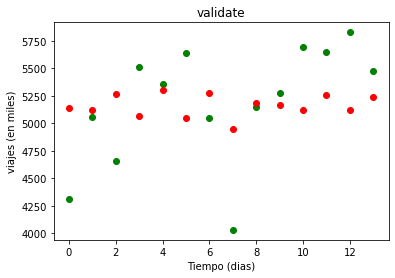

In [32]:
plt.scatter(range(len(testResults)),testResults,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.show()

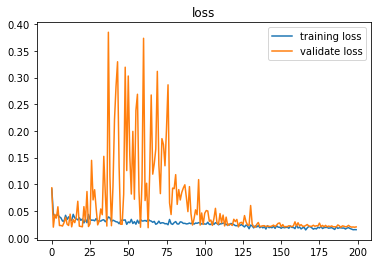

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.legend( ('training loss', 'validate loss'), loc = 'upper right')
plt.show()

In [34]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

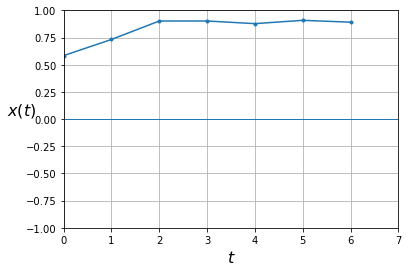

In [35]:
n_steps = 6 #preguntar
plot_series(testX[0, :, 0], testY_scalerInverse[0, 0], testPredict[0, 0])
plt.show()

# Exportar los datos

In [36]:
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-06-07', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(testPredict, index= index_days)
prediccion.columns = ['valor predicho']

prediccion

,valor predicho
2020-06-07,5135.597656
2020-06-08,5121.938477
2020-06-09,5269.761719
2020-06-10,5061.989258
2020-06-11,5305.518066
2020-06-12,5044.112793
2020-06-13,5270.391602
2020-06-14,4950.541992
2020-06-15,5183.632324
2020-06-16,5163.470215


In [37]:
datosReales = df['2020-6-07':'2020-6-20']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']

compara

,real,prediccion
2020-06-07,4308,5135.597656
2020-06-08,5054,5121.938477
2020-06-09,4657,5269.761719
2020-06-10,5512,5061.989258
2020-06-11,5361,5305.518066
2020-06-12,5636,5044.112793
2020-06-13,5046,5270.391602
2020-06-14,4030,4950.541992
2020-06-15,5143,5183.632324
2020-06-16,5272,5163.470215


In [38]:
compara.to_excel('Resultados INE.xlsx', columns=['real', 'prediccion'])

# Prediccion a futuro

In [39]:
# usaremos 7 dias que poseemos para predecir los 7 dias siguientes tras esto compararemos los resultados con los que
# poseemos para ver el grado de error

Dias = df['2020-5-25':'2020-5-31']

In [40]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos, en este caso modificada para ayudarnos a crear
#los distintos sets de entrenmiento para distintos modelos que predeciran 1 dia cada uno

def create_dataset2(dataset, look_back=1, dias=0):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-dias):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back + dias, 0])
  return np.array(dataX), np.array(dataY)

In [41]:
#ahora crearemos los sets para entrenar los modelos
look_back = 7

trainX1, trainY1 = create_dataset2(train, look_back, 1)
testX1, testY1 = create_dataset2(test, look_back, 1)

trainX2, trainY2 = create_dataset2(train, look_back, 2)
testX2, testY2 = create_dataset2(test, look_back, 2)

trainX3, trainY3 = create_dataset2(train, look_back, 3)
testX3, testY3 = create_dataset2(test, look_back, 3)

trainX4, trainY4 = create_dataset2(train, look_back, 4)
testX4, testY4 = create_dataset2(test, look_back, 4)

trainX5, trainY5 = create_dataset2(train, look_back, 5)
testX5, testY5 = create_dataset2(test, look_back, 5)

trainX6, trainY6 = create_dataset2(train, look_back, 6)
testX6, testY6 = create_dataset2(test, look_back, 6)

In [42]:
print(trainX1)

[[0.29111427 0.26459807 0.46600848 0.24231315 0.06713682 0.3486601
  0.38730603]
 [0.26459807 0.46600848 0.24231315 0.06713682 0.3486601  0.38730603
  0.40310293]
 [0.46600848 0.24231315 0.06713682 0.3486601  0.38730603 0.40310293
  0.20394921]
 [0.24231315 0.06713682 0.3486601  0.38730603 0.40310293 0.20394921
  0.10267985]
 [0.06713682 0.3486601  0.38730603 0.40310293 0.20394921 0.10267985
  0.25923836]
 [0.3486601  0.38730603 0.40310293 0.20394921 0.10267985 0.25923836
  0.        ]
 [0.38730603 0.40310293 0.20394921 0.10267985 0.25923836 0.
  0.19464034]
 [0.40310293 0.20394921 0.10267985 0.25923836 0.         0.19464034
  0.37517637]
 [0.20394921 0.10267985 0.25923836 0.         0.19464034 0.37517637
  0.3565585 ]
 [0.10267985 0.25923836 0.         0.19464034 0.37517637 0.3565585
  0.53765875]
 [0.25923836 0.         0.19464034 0.37517637 0.3565585  0.53765875
  0.5145275 ]
 [0.         0.19464034 0.37517637 0.3565585  0.53765875 0.5145275
  0.29196054]
 [0.19464034 0.37517637 0.3

In [43]:
print(trainY1)

[0.20394921 0.10267985 0.25923836 0.         0.19464034 0.37517637
 0.3565585  0.53765875 0.5145275  0.29196054 0.16755998 0.44992954
 0.5328632  0.65500706 0.38166434 0.34442878 0.17433006 0.04569817
 0.21438646 0.40056425 0.387024   0.49393517 0.16755998 0.29703808
 0.3080395  0.5531735  0.5655853  0.4823696  0.59689707 0.6578279
 0.2631876  0.12552893 0.5221439  0.59576875 0.62736255 0.5593794
 0.5379408  0.58194643 0.28688294 0.57856137 0.719323   0.60338503
 0.61354023 0.6662906  0.64767283 0.3590973  0.6787024  0.84344155
 0.82877296 0.7478139  0.88942176 0.8279267 ]


In [44]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]

trainX1 = np.reshape(trainX1, (trainX1.shape[0], trainX1.shape[1], 1))
testX1 = np.reshape(testX1, (testX1.shape[0], testX1.shape[1], 1))

trainX2 = np.reshape(trainX2, (trainX2.shape[0], trainX2.shape[1], 1))
testX2 = np.reshape(testX2, (testX2.shape[0], testX2.shape[1], 1))

trainX3 = np.reshape(trainX3, (trainX3.shape[0], trainX3.shape[1], 1))
testX3 = np.reshape(testX3, (testX3.shape[0], testX3.shape[1], 1))

trainX4 = np.reshape(trainX4, (trainX4.shape[0], trainX4.shape[1], 1))
testX4 = np.reshape(testX4, (testX4.shape[0], testX4.shape[1], 1))

trainX5 = np.reshape(trainX5, (trainX5.shape[0], trainX5.shape[1], 1))
testX5 = np.reshape(testX5, (testX5.shape[0], testX5.shape[1], 1))

trainX6 = np.reshape(trainX6, (trainX6.shape[0], trainX6.shape[1], 1))
testX6 = np.reshape(testX6, (testX6.shape[0], testX6.shape[1], 1))

In [45]:
#creamos los distintos modelos para predecir cada dia

model1 = crear_modeloFF()
history=model1.fit(trainX1, trainY1, epochs=200, validation_data=(testX1,testY1), batch_size=1, verbose=2)

model2 = crear_modeloFF()
history=model2.fit(trainX2, trainY2, epochs=200, validation_data=(testX2,testY2), batch_size=1, verbose=2)

model3 = crear_modeloFF()
history=model3.fit(trainX3, trainY3, epochs=200, validation_data=(testX3,testY3), batch_size=1, verbose=2)

model4 = crear_modeloFF()
history=model4.fit(trainX4, trainY4, epochs=200, validation_data=(testX4,testY4), batch_size=1, verbose=2)

model5 = crear_modeloFF()
history=model5.fit(trainX5, trainY5, epochs=200, validation_data=(testX5,testY5), batch_size=1, verbose=2)

model6 = crear_modeloFF()
history=model6.fit(trainX6, trainY6, epochs=200, validation_data=(testX6,testY6), batch_size=1, verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 7, 20)             1760      
_________________________________________________________________
lstm_4 (LSTM)                (None, 7, 50)             14200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 76,461
Trainable params: 76,461
Non-trainable params: 0
__________________________________________________

52/52 - 0s - loss: 0.0256 - val_loss: 0.0322
Epoch 123/200
52/52 - 0s - loss: 0.0248 - val_loss: 0.0586
Epoch 124/200
52/52 - 0s - loss: 0.0260 - val_loss: 0.0356
Epoch 125/200
52/52 - 0s - loss: 0.0258 - val_loss: 0.0256
Epoch 126/200
52/52 - 0s - loss: 0.0236 - val_loss: 0.0159
Epoch 127/200
52/52 - 0s - loss: 0.0272 - val_loss: 0.0305
Epoch 128/200
52/52 - 0s - loss: 0.0241 - val_loss: 0.0461
Epoch 129/200
52/52 - 0s - loss: 0.0248 - val_loss: 0.0645
Epoch 130/200
52/52 - 0s - loss: 0.0261 - val_loss: 0.0153
Epoch 131/200
52/52 - 0s - loss: 0.0242 - val_loss: 0.0292
Epoch 132/200
52/52 - 0s - loss: 0.0245 - val_loss: 0.0431
Epoch 133/200
52/52 - 0s - loss: 0.0234 - val_loss: 0.0274
Epoch 134/200
52/52 - 0s - loss: 0.0239 - val_loss: 0.0582
Epoch 135/200
52/52 - 0s - loss: 0.0267 - val_loss: 0.0307
Epoch 136/200
52/52 - 0s - loss: 0.0237 - val_loss: 0.0201
Epoch 137/200
52/52 - 0s - loss: 0.0249 - val_loss: 0.0312
Epoch 138/200
52/52 - 0s - loss: 0.0231 - val_loss: 0.0369
Epoch 139/2

Epoch 43/200
51/51 - 0s - loss: 0.0294 - val_loss: 0.0497
Epoch 44/200
51/51 - 0s - loss: 0.0330 - val_loss: 0.2271
Epoch 45/200
51/51 - 0s - loss: 0.0325 - val_loss: 0.1368
Epoch 46/200
51/51 - 0s - loss: 0.0317 - val_loss: 0.0734
Epoch 47/200
51/51 - 0s - loss: 0.0298 - val_loss: 0.3589
Epoch 48/200
51/51 - 0s - loss: 0.0364 - val_loss: 0.0865
Epoch 49/200
51/51 - 0s - loss: 0.0299 - val_loss: 0.1630
Epoch 50/200
51/51 - 0s - loss: 0.0274 - val_loss: 0.2122
Epoch 51/200
51/51 - 0s - loss: 0.0337 - val_loss: 0.2556
Epoch 52/200
51/51 - 0s - loss: 0.0327 - val_loss: 0.3255
Epoch 53/200
51/51 - 0s - loss: 0.0309 - val_loss: 0.1765
Epoch 54/200
51/51 - 0s - loss: 0.0285 - val_loss: 0.3638
Epoch 55/200
51/51 - 0s - loss: 0.0333 - val_loss: 0.5240
Epoch 56/200
51/51 - 0s - loss: 0.0336 - val_loss: 0.2250
Epoch 57/200
51/51 - 0s - loss: 0.0228 - val_loss: 0.8789
Epoch 58/200
51/51 - 0s - loss: 0.0390 - val_loss: 0.5836
Epoch 59/200
51/51 - 0s - loss: 0.0320 - val_loss: 0.1102
Epoch 60/200
5

Epoch 183/200
51/51 - 0s - loss: 0.0245 - val_loss: 0.0192
Epoch 184/200
51/51 - 0s - loss: 0.0231 - val_loss: 0.0719
Epoch 185/200
51/51 - 0s - loss: 0.0243 - val_loss: 0.0503
Epoch 186/200
51/51 - 0s - loss: 0.0239 - val_loss: 0.0653
Epoch 187/200
51/51 - 0s - loss: 0.0236 - val_loss: 0.0229
Epoch 188/200
51/51 - 0s - loss: 0.0228 - val_loss: 0.0354
Epoch 189/200
51/51 - 0s - loss: 0.0229 - val_loss: 0.0405
Epoch 190/200
51/51 - 0s - loss: 0.0204 - val_loss: 0.1058
Epoch 191/200
51/51 - 0s - loss: 0.0233 - val_loss: 0.0623
Epoch 192/200
51/51 - 0s - loss: 0.0236 - val_loss: 0.0280
Epoch 193/200
51/51 - 0s - loss: 0.0229 - val_loss: 0.0197
Epoch 194/200
51/51 - 0s - loss: 0.0245 - val_loss: 0.0282
Epoch 195/200
51/51 - 0s - loss: 0.0225 - val_loss: 0.0388
Epoch 196/200
51/51 - 0s - loss: 0.0239 - val_loss: 0.0529
Epoch 197/200
51/51 - 0s - loss: 0.0212 - val_loss: 0.0846
Epoch 198/200
51/51 - 0s - loss: 0.0226 - val_loss: 0.0420
Epoch 199/200
51/51 - 0s - loss: 0.0239 - val_loss: 0.08

50/50 - 0s - loss: 0.0249 - val_loss: 0.1338
Epoch 105/200
50/50 - 0s - loss: 0.0245 - val_loss: 0.2990
Epoch 106/200
50/50 - 0s - loss: 0.0225 - val_loss: 0.1485
Epoch 107/200
50/50 - 0s - loss: 0.0216 - val_loss: 0.3512
Epoch 108/200
50/50 - 0s - loss: 0.0249 - val_loss: 0.2603
Epoch 109/200
50/50 - 0s - loss: 0.0233 - val_loss: 0.3449
Epoch 110/200
50/50 - 0s - loss: 0.0221 - val_loss: 0.3508
Epoch 111/200
50/50 - 0s - loss: 0.0223 - val_loss: 0.6461
Epoch 112/200
50/50 - 0s - loss: 0.0213 - val_loss: 0.2141
Epoch 113/200
50/50 - 0s - loss: 0.0240 - val_loss: 0.1581
Epoch 114/200
50/50 - 0s - loss: 0.0224 - val_loss: 0.5893
Epoch 115/200
50/50 - 0s - loss: 0.0284 - val_loss: 0.1437
Epoch 116/200
50/50 - 0s - loss: 0.0242 - val_loss: 0.2279
Epoch 117/200
50/50 - 0s - loss: 0.0239 - val_loss: 0.1495
Epoch 118/200
50/50 - 0s - loss: 0.0250 - val_loss: 0.1467
Epoch 119/200
50/50 - 0s - loss: 0.0239 - val_loss: 0.0791
Epoch 120/200
50/50 - 0s - loss: 0.0232 - val_loss: 0.2402
Epoch 121/2

49/49 - 0s - loss: 0.0361 - val_loss: 0.0804
Epoch 25/200
49/49 - 0s - loss: 0.0316 - val_loss: 0.0160
Epoch 26/200
49/49 - 0s - loss: 0.0334 - val_loss: 0.1961
Epoch 27/200
49/49 - 0s - loss: 0.0341 - val_loss: 0.2004
Epoch 28/200
49/49 - 0s - loss: 0.0293 - val_loss: 0.5017
Epoch 29/200
49/49 - 0s - loss: 0.0344 - val_loss: 0.1045
Epoch 30/200
49/49 - 0s - loss: 0.0262 - val_loss: 0.0990
Epoch 31/200
49/49 - 0s - loss: 0.0340 - val_loss: 0.5120
Epoch 32/200
49/49 - 0s - loss: 0.0323 - val_loss: 0.1586
Epoch 33/200
49/49 - 0s - loss: 0.0334 - val_loss: 0.3899
Epoch 34/200
49/49 - 0s - loss: 0.0263 - val_loss: 0.6668
Epoch 35/200
49/49 - 0s - loss: 0.0269 - val_loss: 0.5042
Epoch 36/200
49/49 - 0s - loss: 0.0312 - val_loss: 0.3615
Epoch 37/200
49/49 - 0s - loss: 0.0293 - val_loss: 0.7960
Epoch 38/200
49/49 - 0s - loss: 0.0249 - val_loss: 0.6836
Epoch 39/200
49/49 - 0s - loss: 0.0326 - val_loss: 0.0876
Epoch 40/200
49/49 - 0s - loss: 0.0251 - val_loss: 0.3315
Epoch 41/200
49/49 - 0s - l

Epoch 165/200
49/49 - 0s - loss: 0.0184 - val_loss: 0.3377
Epoch 166/200
49/49 - 0s - loss: 0.0201 - val_loss: 0.1142
Epoch 167/200
49/49 - 0s - loss: 0.0240 - val_loss: 0.0930
Epoch 168/200
49/49 - 0s - loss: 0.0222 - val_loss: 0.1494
Epoch 169/200
49/49 - 0s - loss: 0.0194 - val_loss: 0.1694
Epoch 170/200
49/49 - 0s - loss: 0.0188 - val_loss: 0.1868
Epoch 171/200
49/49 - 0s - loss: 0.0197 - val_loss: 0.1753
Epoch 172/200
49/49 - 0s - loss: 0.0210 - val_loss: 0.0876
Epoch 173/200
49/49 - 0s - loss: 0.0201 - val_loss: 0.1539
Epoch 174/200
49/49 - 0s - loss: 0.0192 - val_loss: 0.1392
Epoch 175/200
49/49 - 0s - loss: 0.0190 - val_loss: 0.1986
Epoch 176/200
49/49 - 0s - loss: 0.0194 - val_loss: 0.2439
Epoch 177/200
49/49 - 0s - loss: 0.0187 - val_loss: 0.1797
Epoch 178/200
49/49 - 0s - loss: 0.0200 - val_loss: 0.1227
Epoch 179/200
49/49 - 0s - loss: 0.0188 - val_loss: 0.1821
Epoch 180/200
49/49 - 0s - loss: 0.0199 - val_loss: 0.2217
Epoch 181/200
49/49 - 0s - loss: 0.0181 - val_loss: 0.19

Epoch 86/200
48/48 - 0s - loss: 0.0242 - val_loss: 0.3652
Epoch 87/200
48/48 - 0s - loss: 0.0207 - val_loss: 0.3615
Epoch 88/200
48/48 - 0s - loss: 0.0243 - val_loss: 0.6203
Epoch 89/200
48/48 - 0s - loss: 0.0194 - val_loss: 0.6393
Epoch 90/200
48/48 - 0s - loss: 0.0224 - val_loss: 0.5546
Epoch 91/200
48/48 - 0s - loss: 0.0228 - val_loss: 0.3946
Epoch 92/200
48/48 - 0s - loss: 0.0217 - val_loss: 0.5879
Epoch 93/200
48/48 - 0s - loss: 0.0225 - val_loss: 0.4370
Epoch 94/200
48/48 - 0s - loss: 0.0195 - val_loss: 0.5520
Epoch 95/200
48/48 - 0s - loss: 0.0173 - val_loss: 0.6647
Epoch 96/200
48/48 - 0s - loss: 0.0255 - val_loss: 0.4353
Epoch 97/200
48/48 - 0s - loss: 0.0210 - val_loss: 0.4368
Epoch 98/200
48/48 - 0s - loss: 0.0216 - val_loss: 0.6646
Epoch 99/200
48/48 - 0s - loss: 0.0237 - val_loss: 0.6381
Epoch 100/200
48/48 - 0s - loss: 0.0212 - val_loss: 0.5192
Epoch 101/200
48/48 - 0s - loss: 0.0236 - val_loss: 0.2277
Epoch 102/200
48/48 - 0s - loss: 0.0197 - val_loss: 0.2821
Epoch 103/2

Epoch 6/200
47/47 - 0s - loss: 0.0419 - val_loss: 0.0862
Epoch 7/200
47/47 - 0s - loss: 0.0388 - val_loss: 0.0321
Epoch 8/200
47/47 - 0s - loss: 0.0404 - val_loss: 0.0273
Epoch 9/200
47/47 - 0s - loss: 0.0469 - val_loss: 0.0458
Epoch 10/200
47/47 - 0s - loss: 0.0454 - val_loss: 0.0456
Epoch 11/200
47/47 - 0s - loss: 0.0469 - val_loss: 0.0303
Epoch 12/200
47/47 - 0s - loss: 0.0458 - val_loss: 0.0278
Epoch 13/200
47/47 - 0s - loss: 0.0409 - val_loss: 0.0285
Epoch 14/200
47/47 - 0s - loss: 0.0421 - val_loss: 0.0619
Epoch 15/200
47/47 - 0s - loss: 0.0381 - val_loss: 0.0591
Epoch 16/200
47/47 - 0s - loss: 0.0444 - val_loss: 0.0597
Epoch 17/200
47/47 - 0s - loss: 0.0403 - val_loss: 0.0276
Epoch 18/200
47/47 - 0s - loss: 0.0467 - val_loss: 0.0341
Epoch 19/200
47/47 - 0s - loss: 0.0386 - val_loss: 0.0432
Epoch 20/200
47/47 - 0s - loss: 0.0419 - val_loss: 0.0490
Epoch 21/200
47/47 - 0s - loss: 0.0424 - val_loss: 0.0669
Epoch 22/200
47/47 - 0s - loss: 0.0433 - val_loss: 0.0688
Epoch 23/200
47/47

Epoch 147/200
47/47 - 0s - loss: 0.0149 - val_loss: 0.0396
Epoch 148/200
47/47 - 0s - loss: 0.0130 - val_loss: 0.0189
Epoch 149/200
47/47 - 0s - loss: 0.0160 - val_loss: 0.0285
Epoch 150/200
47/47 - 0s - loss: 0.0143 - val_loss: 0.0415
Epoch 151/200
47/47 - 0s - loss: 0.0157 - val_loss: 0.0385
Epoch 152/200
47/47 - 0s - loss: 0.0131 - val_loss: 0.0309
Epoch 153/200
47/47 - 0s - loss: 0.0141 - val_loss: 0.0307
Epoch 154/200
47/47 - 0s - loss: 0.0145 - val_loss: 0.0210
Epoch 155/200
47/47 - 0s - loss: 0.0163 - val_loss: 0.0440
Epoch 156/200
47/47 - 0s - loss: 0.0159 - val_loss: 0.0116
Epoch 157/200
47/47 - 0s - loss: 0.0147 - val_loss: 0.0147
Epoch 158/200
47/47 - 0s - loss: 0.0140 - val_loss: 0.0293
Epoch 159/200
47/47 - 0s - loss: 0.0144 - val_loss: 0.0340
Epoch 160/200
47/47 - 0s - loss: 0.0120 - val_loss: 0.0490
Epoch 161/200
47/47 - 0s - loss: 0.0148 - val_loss: 0.0604
Epoch 162/200
47/47 - 0s - loss: 0.0155 - val_loss: 0.0212
Epoch 163/200
47/47 - 0s - loss: 0.0165 - val_loss: 0.02

# Preparamos los datos para el test

In [46]:
# cargamos el dataframe en la variable dataset
dataset = Dias.values

# convertimos los enteros en floats
dataset = dataset.astype('float32')

# normalizamos los datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [47]:
#remodelamos los datos
testX = np.reshape(dataset, (1, 7, 1))

# Predicciones para la proxima semana

In [48]:
results = []

parcial=model.predict(testX)
results.append(parcial[0])

parcial=model1.predict(testX)
results.append(parcial[0])

parcial=model2.predict(testX)
results.append(parcial[0])

parcial=model3.predict(testX)
results.append(parcial[0])

parcial=model4.predict(testX)
results.append(parcial[0])

parcial=model5.predict(testX)
results.append(parcial[0])

parcial=model6.predict(testX)
results.append(parcial[0])

results = np.reshape(results, (7, 1))
print(results)

[[0.6169466 ]
 [0.7576093 ]
 [0.89474046]
 [0.8964505 ]
 [0.9039918 ]
 [0.8829428 ]
 [0.14538303]]


# Re-Convertimos los resultados

In [49]:
inverted = scaler.inverse_transform(results)

#en nuestro problema no tienen sentido los decimales pues no se pueden hacer 0.5 viajes o 0.25 viajes
inverted = inverted.round()
inverted = inverted.astype(int)

inverted

array([[5020],
       [5172],
       [5321],
       [5323],
       [5331],
       [5308],
       [4509]])

# Visualizamos el pronostico

<AxesSubplot:>

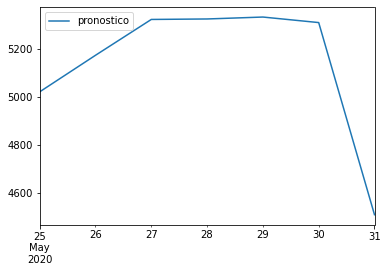

In [50]:
e_date = datetime.datetime.strptime('2020-05-31', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-05-25', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(inverted, index= index_days)
prediccion.columns = ['pronostico']
prediccion.plot()

In [51]:
datosReales = df['2020-5-25':'2020-5-31']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']

compara

,real,prediccion
2020-05-25,4688,5020
2020-05-26,5272,5172
2020-05-27,5220,5321
2020-05-28,4933,5323
2020-05-29,5435,5331
2020-05-30,5217,5308
2020-05-31,4351,4509


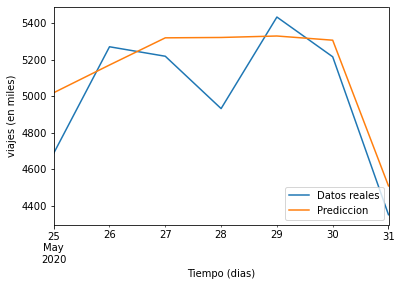

In [52]:
compara['real'].plot()
compara['prediccion'].plot()
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.legend( ('Datos reales', 'Prediccion'), loc = 'lower right')

In [53]:
# calculamos las metricas de error
testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(prediccion, datosReales)
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del test: 182.29 MAE
Resultado del test: 46655.14 MSE
Resultado del test: 216.00 RMSE
Resultado del test: 4.20 CVRMSE
Resultado del test: 3.56 MAPE


In [54]:
# calculamos las metricas de error para cada dia por separado
for i in range(7):
    testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(prediccion.values[i], datosReales.values[i])
    day = i + 1
    print('Resultado del test dia %d: %.2f MAE' % (day, testScore_MAE))
    print('Resultado del test dia %d: %.2f MSE' % (day, testScore_MSE))
    print('Resultado del test dia %d: %.2f RMSE' % (day, testScore_RMSE))
    print('Resultado del test dia %d: %.2f CVRMSE' % (day, testScore_CVRMSE))
    print('Resultado del test dia %d: %.2f MAPE \n' % (day, testScore_MAPE))

Resultado del test dia 1: 332.00 MAE
Resultado del test dia 1: 110224.00 MSE
Resultado del test dia 1: 332.00 RMSE
Resultado del test dia 1: 6.61 CVRMSE
Resultado del test dia 1: 6.61 MAPE 

Resultado del test dia 2: 100.00 MAE
Resultado del test dia 2: 10000.00 MSE
Resultado del test dia 2: 100.00 RMSE
Resultado del test dia 2: 1.93 CVRMSE
Resultado del test dia 2: 1.93 MAPE 

Resultado del test dia 3: 101.00 MAE
Resultado del test dia 3: 10201.00 MSE
Resultado del test dia 3: 101.00 RMSE
Resultado del test dia 3: 1.90 CVRMSE
Resultado del test dia 3: 1.90 MAPE 

Resultado del test dia 4: 390.00 MAE
Resultado del test dia 4: 152100.00 MSE
Resultado del test dia 4: 390.00 RMSE
Resultado del test dia 4: 7.33 CVRMSE
Resultado del test dia 4: 7.33 MAPE 

Resultado del test dia 5: 104.00 MAE
Resultado del test dia 5: 10816.00 MSE
Resultado del test dia 5: 104.00 RMSE
Resultado del test dia 5: 1.95 CVRMSE
Resultado del test dia 5: 1.95 MAPE 

Resultado del test dia 6: 91.00 MAE
Resultado de